## TabNetのサンプルコード

In [1]:
%load_ext lab_black

In [2]:
# ライブラリーのインポート
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from pytorch_tabnet.tab_model import TabNetRegressor

import os
import random
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# ボストンの住宅価格データ
from sklearn.datasets import load_boston

# 前処理
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 評価指標
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [3]:
print(torch.__version__)

1.9.0+cu102


In [4]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ["PYTHONHASHSEED"] = str(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


seed_everything(10)

In [5]:
# データセットの読込み
boston = load_boston()

# 説明変数の格納
df = pd.DataFrame(boston.data, columns=boston.feature_names)
# 目的変数の追加
df["MEDV"] = boston.target

# データの中身を確認
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


#### 前処理

In [6]:
# ランダムシード値
RANDOM_STATE = 10

# 学習データと評価データの割合
TEST_SIZE = 0.2

# 学習データと評価データを作成
x_train, x_test, y_train, y_test = train_test_split(
    df.iloc[:, 0 : df.shape[1] - 1],
    df.iloc[:, df.shape[1] - 1],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

# trainのデータセットの2割をモデル学習時のバリデーションデータとして利用する
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

In [7]:
# モデルのパラメータ
tabnet_params = dict(
    n_d=15,
    n_a=15,
    n_steps=8,
    gamma=0.2,
    seed=10,
    lambda_sparse=1e-3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
    mask_type="entmax",
    scheduler_params=dict(
        max_lr=0.05,
        steps_per_epoch=int(x_train.shape[0] / 256),
        epochs=200,
        is_batch_level=True,
    ),
    verbose=5,
)

In [8]:
# model
model = TabNetRegressor(**tabnet_params)

model.fit(
    X_train=x_train.values,
    y_train=y_train.values.reshape(-1, 1),
    eval_set=[(x_valid.values, y_valid.values.reshape(-1, 1))],
    eval_metric=["mae"],
    max_epochs=200,
    patience=30,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=2,
    drop_last=False,
    loss_fn=torch.nn.functional.l1_loss,
)

Device used : cpu
epoch 0  | loss: 14.56976| val_0_mae: 211.13282|  0:00:00s
epoch 5  | loss: 3.11874 | val_0_mae: 29.55905|  0:00:04s
epoch 10 | loss: 2.43038 | val_0_mae: 15.34086|  0:00:07s
epoch 15 | loss: 2.0079  | val_0_mae: 8.45243 |  0:00:11s
epoch 20 | loss: 1.81357 | val_0_mae: 7.34933 |  0:00:15s
epoch 25 | loss: 1.72256 | val_0_mae: 6.09449 |  0:00:19s
epoch 30 | loss: 1.86989 | val_0_mae: 6.617   |  0:00:23s
epoch 35 | loss: 1.69414 | val_0_mae: 7.30948 |  0:00:27s
epoch 40 | loss: 1.89843 | val_0_mae: 5.34765 |  0:00:32s
epoch 45 | loss: 1.55784 | val_0_mae: 5.5474  |  0:00:36s
epoch 50 | loss: 1.60511 | val_0_mae: 5.47405 |  0:00:40s
epoch 55 | loss: 1.39825 | val_0_mae: 6.06403 |  0:00:44s
epoch 60 | loss: 1.5421  | val_0_mae: 5.75652 |  0:00:48s
epoch 65 | loss: 1.72234 | val_0_mae: 5.58837 |  0:00:53s
epoch 70 | loss: 1.5995  | val_0_mae: 4.79066 |  0:00:58s
epoch 75 | loss: 1.71995 | val_0_mae: 6.5499  |  0:01:06s
epoch 80 | loss: 1.26165 | val_0_mae: 5.11483 |  0:01

In [9]:
# Feature Importance
model.feature_importances_

array([0.0661633 , 0.06501721, 0.07251373, 0.06433994, 0.07286116,
       0.11059525, 0.07961715, 0.07393975, 0.06777524, 0.10440052,
       0.06827378, 0.06359717, 0.09090581])

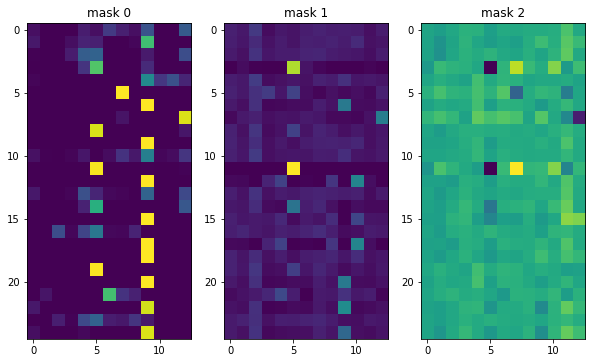

In [10]:
# Mask(Local interpretability)
explain_matrix, masks = model.explain(x_test.values)

fig, axs = plt.subplots(1, 3, figsize=(10, 7))

for i in range(3):
    axs[i].imshow(masks[i][:25])
    axs[i].set_title(f"mask {i}")

In [11]:
# TabNet推論
y_pred = model.predict(x_test.values)

In [12]:
# 評価
def calculate_scores(true, pred):
    """全ての評価指標を計算する

    Parameters
    ----------
    true (np.array)       : 実測値
    pred (np.array)       : 予測値

    Returns
    -------
    scores (pd.DataFrame) : 各評価指標を纏めた結果

    """
    scores = {}
    scores = pd.DataFrame(
        {
            "R2": r2_score(true, pred),
            "MAE": mean_absolute_error(true, pred),
            "MSE": mean_squared_error(true, pred),
            "RMSE": np.sqrt(mean_squared_error(true, pred)),
        },
        index=["scores"],
    )
    return scores

In [13]:
scores = calculate_scores(y_test, y_pred)
print(scores)

             R2       MAE        MSE      RMSE
scores  0.90156  2.466226  10.294959  3.208576
